# 05c: CNN-LSTM Model Optimization and Evaluation

This notebook provides a comprehensive evaluation and interpretability analysis of the trained CNN-LSTM model for ICU mortality prediction, focusing on model performance assessment and clinical insights.



#### 1. Imports and Configuration

Import all necessary libraries for model evaluation and visualization

In [ ]:
# Imports and Configuration
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
import shap
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt



## 2. Load Trained CNN-LSTM Model
This section loads the trained CNN-LSTM model from disk. The model was previously trained on ICU patient data and saved for downstream evaluation and interpretability analysis.


In [39]:
# Define the path to the saved model
model_path_to_load = '/content/sample_data/enhanced_model_36hour.keras'  # Or 'base_model_36hour.keras'

# Load the model
loaded_model = load_model(model_path_to_load)



/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 36 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## 3. Load Test Data for Evaluation
This section loads the preprocessed test data required for evaluating the trained CNN-LSTM model. The test data includes time series features, static patient features, and ground truth labels.


In [40]:
class KerasModelWrapper:
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        return (self.model.predict(X, verbose=0).flatten() > 0.5).astype(int)
    def predict_proba(self, X):
        proba = self.model.predict(X, verbose=0).flatten()
        return np.vstack([1 - proba, proba]).T  # shape: (n_samples, 2)

keras_model = KerasModelWrapper(loaded_model)

data = np.load('/content/sample_data/cnn_lstm_36hour_data.npz', allow_pickle=True)
X_test_final = data['X_test']
static_test_final = data['static_test']
y_test_final = data['y_test']




# 4. Model Evaluation

**Confusion Matrix Results:**

- **True Negatives (Top-Left):** 390 cases were correctly predicted as negative (survived).
- **False Positives (Top-Right):** 299 cases were incorrectly predicted as positive (died) when they actually survived. This represents Type I errors.
- **False Negatives (Bottom-Left):** 19 cases were incorrectly predicted as negative (survived) when they actually died. This represents Type II errors.
- **True Positives (Bottom-Right):** 92 cases were correctly predicted as positive (died).


Generating Confusion Matrix...


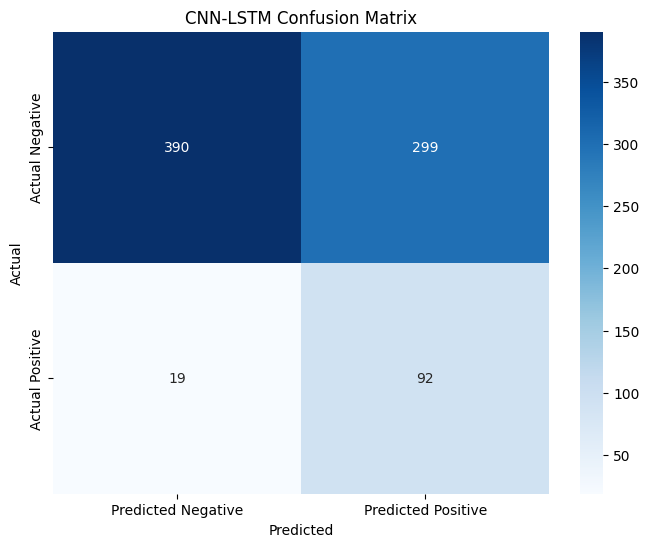

Confusion matrix generated.


In [ ]:
# Plot Confusion Matrix
print("Generating Confusion Matrix...")

# Use the wrapped model to get predictions
y_pred = keras_model.predict([X_test_final, static_test_final])

# Calculate the confusion matrix
cm = confusion_matrix(y_test_final, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN-LSTM Confusion Matrix')
plt.show()

print("Confusion matrix generated.")

**Precision-Recall Curve:**

The Precision-Recall curve shows the trade-off between precision and recall at different probability thresholds.

*   **Precision** is the ability of the classifier not to label as positive a sample that is negative.
*   **Recall** is the ability of the classifier to find all the positive samples.

The **Area Under the Precision-Recall Curve (AUPRC)** is a single number summarizing the curve. A higher AUPRC indicates better performance, especially in imbalanced datasets where the positive class is rare. In this case, the AUPRC of 0.36 suggests that the model's ability to achieve high precision and high recall simultaneously is limited. This aligns with the confusion matrix results which showed a relatively high number of false positives.

Generating Precision-Recall Curve...


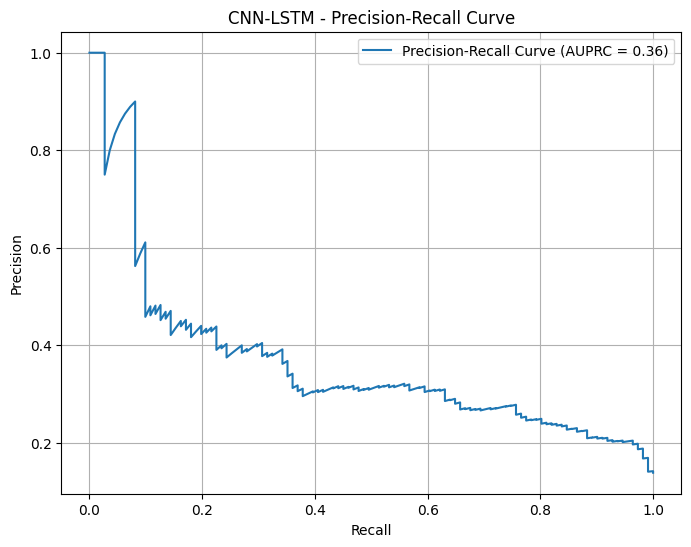

Precision-Recall Curve generated with AUPRC: 0.36


In [ ]:
print("Generating Precision-Recall Curve...")

# Get predicted probabilities for the positive class
y_proba = keras_model.predict_proba([X_test_final, static_test_final])[:, 1]

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test_final, y_proba)

# Calculate Area Under the Precision-Recall Curve (AUPRC)
auprc = auc(recall, precision)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUPRC = {auprc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('CNN-LSTM - Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

print(f"Precision-Recall Curve generated with AUPRC: {auprc:.2f}")

**ROC Curve:**

The ROC curve shows the model's ability to discriminate between positive and negative classes across various thresholds. The **Area Under the ROC Curve (AUROC)** quantifies this discriminatory power, with a value closer to 1 indicating better performance. In this case, an AUROC of 0.77 suggests that the model has moderate discriminatory ability. The curve being above the random guess line indicates that the model performs better than random chance.

Generating ROC Curve...


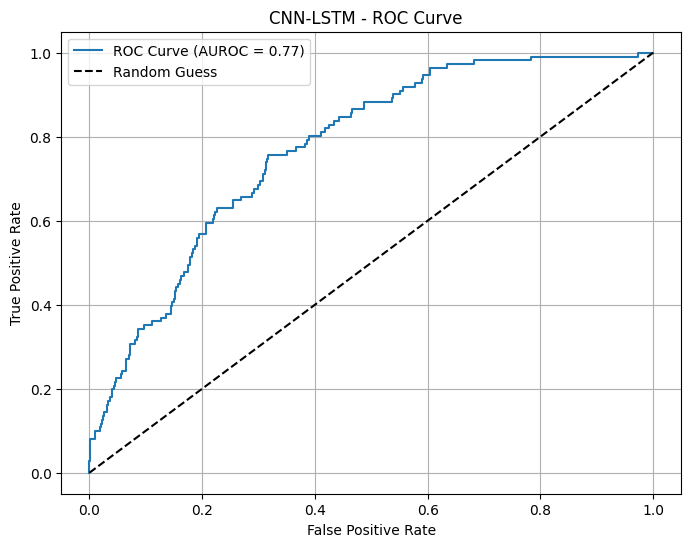

ROC Curve generated with AUROC: 0.77


In [43]:

print("Generating ROC Curve...")

# Get predicted probabilities for the positive class
y_proba = keras_model.predict_proba([X_test_final, static_test_final])[:, 1]

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test_final, y_proba)

# Calculate Area Under the ROC Curve (AUROC)
auroc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUROC = {auroc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess') # Add random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN-LSTM - ROC Curve  ')
plt.legend()
plt.grid(True)
plt.show()

print(f"ROC Curve generated with AUROC: {auroc:.2f}")

In [44]:
# Dynamic (time series) features
time_series_features = [
    'HR', 'SysABP', 'DiasABP', 'MAP', 'NISysABP', 'NIDiasABP', 'NIMAP', 'MechVent',
    'RespRate', 'SaO2', 'FiO2', 'PaO2', 'PaCO2',
    'Creatinine', 'BUN', 'Urine',
    'Na', 'K', 'Glucose', 'Lactate', 'HCO3', 'pH',
    'GCS', 'Temp',
    # Clinically meaningful combinations of vitals
    'Shock Index',          # HR / SysABP
    'PaO2/FiO2 ratio',      # PaO₂ / FiO₂
    'Pulse Pressure',       # SysABP − DiasABP
    'MAP to HR ratio'       # MAP / HR
]

# Static features
static_features = [
    'Age', 'Gender', 'Height', 'Weight', 'ICUType', 'SAPS-I', 'SOFA'
]

target_col = 'In-hospital_death'



In [45]:

# Load trained model and test data
model_path = '/content/sample_data/enhanced_model_36hour.keras'
data_path = '/content/sample_data/cnn_lstm_36hour_data.npz'

try:
    # Load trained CNN-LSTM model
    model = load_model(model_path)
    print(f"Model loaded from {model_path}")

    # Load preprocessed test data
    data = np.load(data_path, allow_pickle=True)
    X_test_final = data['X_test']
    static_test_final = data['static_test']
    y_test_final = data['y_test']

    print(f"Data loaded from {data_path}")
    print(f"  Time series shape: {X_test_final.shape}")
    print(f"  Static features shape: {static_test_final.shape}")
    print(f"  Labels shape: {y_test_final.shape}")

except FileNotFoundError as e:
    print(f"File not found: {e}")
except Exception as e:
    print(f"Error: {e}")

# Prepare data for SHAP analysis
background_size = 50
sample_size = 50

# Load all data splits for comprehensive analysis
X_train_final = data['X_train']
X_val_final = data['X_val']
static_train_final = data['static_train']
static_val_final = data['static_val']

if X_test_final.shape[0] >= background_size + sample_size:
    # Create background and sample sets from test data
    X_background = X_test_final[:background_size]
    static_background = static_test_final[:background_size]
    X_sample = X_test_final[background_size:background_size + sample_size]
    static_sample = static_test_final[background_size:background_size + sample_size]

    print(f"\n SHAP datasets prepared:")
    print(f"  Background samples: {background_size}")
    print(f"  Analysis samples: {sample_size}")

    # Average time series over temporal dimension for SHAP
    X_background_mean = np.mean(X_background, axis=1)
    X_sample_mean = np.mean(X_sample, axis=1)

    # Concatenate time series and static features
    background_concat = np.concatenate([X_background_mean, static_background], axis=1)
    sample_concat = np.concatenate([X_sample_mean, static_sample], axis=1)

    print(f"  Background concatenated shape: {background_concat.shape}")
    print(f"  Sample concatenated shape: {sample_concat.shape}")

    # Create feature names for interpretability
    if 'time_series_features' in locals() and 'static_features' in locals():
        feature_names = time_series_features + static_features
        if len(feature_names) != sample_concat.shape[1]:
            print(f"Feature mismatch: {len(feature_names)} names vs {sample_concat.shape[1]} features")
            feature_names = [f'feature_{i}' for i in range(sample_concat.shape[1])]
    else:
        feature_names = [f'feature_{i}' for i in range(sample_concat.shape[1])]
        print("  Using generic feature names")

    print(f"Feature names created: {len(feature_names)} features")

else:
    print(f"Insufficient test samples: {X_test_final.shape[0]} available, {background_size + sample_size} needed")

Model loaded from /content/sample_data/enhanced_model_36hour.keras
Data loaded from /content/sample_data/cnn_lstm_36hour_data.npz
  Time series shape: (800, 36, 28)
  Static features shape: (800, 7)
  Labels shape: (800,)

 SHAP datasets prepared:
  Background samples: 50
  Analysis samples: 50
  Background concatenated shape: (50, 35)
  Sample concatenated shape: (50, 35)
Feature names created: 35 features


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 36 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Generating SHAP force plot...
Analyzing patient 0...
Using 2D SHAP values. Shape: (10, 35)
Base value (average prediction): 0.7743


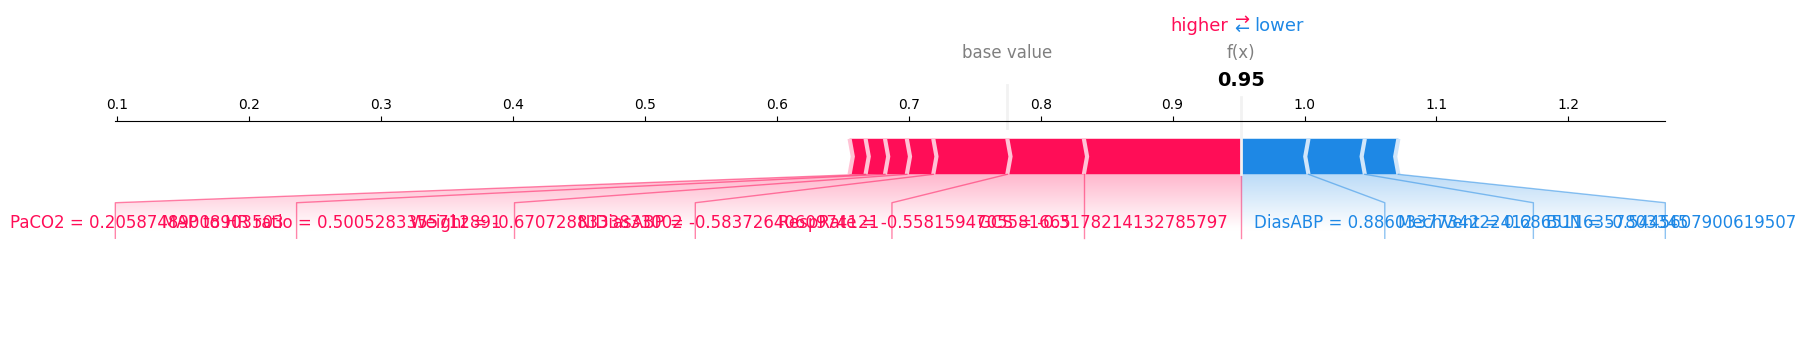

In [46]:
# SHAP Force Plot - Individual Patient Analysis
import shap
import numpy as np
import matplotlib.pyplot as plt

if 'shap_values' in locals() and 'sample_concat' in locals():
    print("Generating SHAP force plot...")

    # Select patient instance to analyze
    instance_index = 0
    if instance_index < sample_concat.shape[0]:
        print(f"Analyzing patient {instance_index}...")

        # Handle 3D SHAP values
        if len(np.shape(shap_values)) == 3:
            if np.shape(shap_values)[2] > 1:
                shap_values_2d = shap_values[:, :, 1]  # Positive class
                print(f"Using positive class SHAP values. Shape: {np.shape(shap_values_2d)}")
            else:
                shap_values_2d = shap_values[:, :, 0]  # Single output
                print(f"Using single output SHAP values. Shape: {np.shape(shap_values_2d)}")
        else:
            shap_values_2d = shap_values
            print(f"Using 2D SHAP values. Shape: {np.shape(shap_values_2d)}")

        # Extract values for selected patient
        shap_values_instance = shap_values_2d[instance_index, :]
        feature_values_instance = sample_concat[instance_index, :]

        # Ensure feature names are available
        if 'feature_names' not in locals():
            print("Warning: Using generic feature names.")
            feature_names = [f'feature_{i}' for i in range(sample_concat.shape[1])]

        # Get base value from explainer
        if 'explainer' in locals():
            base_value = explainer.expected_value
            print(f"Base value (average prediction): {base_value:.4f}")
        else:
            print("Warning: Explainer not found, using fallback base value.")
            if 'predict_fn' in locals() and 'background_concat' in locals():
                base_value = np.mean(predict_fn(background_concat))
                print(f"Calculated base value: {base_value:.4f}")
            else:
                base_value = 0.0
                print("Using default base value: 0.0")

        # Generate force plot
        shap.force_plot(base_value, shap_values_instance, feature_values_instance,
                        feature_names=feature_names, matplotlib=True)
        plt.show()

    else:
        print(f"Error: Instance {instance_index} out of bounds for {sample_concat.shape[0]} samples.")

else:
    print("Error: SHAP values not found. Run SHAP calculation cell first.")

In [47]:

print("Starting SHAP analysis...")

def predict_fn(data):
    """
    Prediction wrapper for multi-input CNN-LSTM model.
    Splits concatenated features back into time series and static components.
    """
    n_ts_features = len(time_series_features)

    # Split concatenated data
    ts_data = data[:, :n_ts_features]
    static_data = data[:, n_ts_features:]

    # Expand time series to original temporal dimension
    timesteps = X_test_final.shape[1]
    ts_data_expanded = np.repeat(ts_data[:, np.newaxis, :], timesteps, axis=1)

    # Generate predictions
    predictions = model.predict([ts_data_expanded, static_data], verbose=0)
    return predictions.flatten()

print("Prediction function defined")

# Test prediction function
try:
    test_pred = predict_fn(sample_concat[:2])
    print(f"Prediction test successful: shape {test_pred.shape}, values {test_pred}")
except Exception as e:
    print(f"Prediction test failed: {e}")
    raise

# Create SHAP explainer
print("\nCreating SHAP KernelExplainer...")
try:
    # Use subset for computational efficiency
    background_sample = background_concat[:25]
    explainer = shap.KernelExplainer(predict_fn, background_sample)
    print(f"Explainer created with {background_sample.shape[0]} background samples")

    # Calculate SHAP values for sample subset
    sample_subset = sample_concat[:10]
    print(f"\nCalculating SHAP values for {sample_subset.shape[0]} patients...")
    print("   This may take a few minutes...")

    shap_values = explainer.shap_values(sample_subset, nsamples=100)

    # Update sample_concat to match calculated subset
    sample_concat = sample_subset

    print(f"SHAP analysis complete!")
    print(f"   SHAP values shape: {np.array(shap_values).shape}")
    print(f"   Sample data shape: {sample_concat.shape}")

except Exception as e:
    print(f" SHAP calculation failed: {e}")
    print("   Consider reducing background_size or sample_size for memory constraints")

Starting SHAP analysis...
Prediction function defined
Prediction test successful: shape (2,), values [0.9519842 0.008199 ]

Creating SHAP KernelExplainer...
Explainer created with 25 background samples

Calculating SHAP values for 10 patients...
   This may take a few minutes...


  0%|          | 0/10 [00:00<?, ?it/s]

SHAP analysis complete!
   SHAP values shape: (10, 35)
   Sample data shape: (10, 35)


In [48]:
# SHAP Analysis - Calculate Feature Importance
import shap
import numpy as np

print("Starting SHAP analysis...")

def predict_fn(data):
    """
    Prediction wrapper for multi-input CNN-LSTM model.
    Splits concatenated features back into time series and static components.
    """
    n_ts_features = len(time_series_features)

    # Split concatenated data
    ts_data = data[:, :n_ts_features]
    static_data = data[:, n_ts_features:]

    # Expand time series to original temporal dimension
    timesteps = X_test_final.shape[1]
    ts_data_expanded = np.repeat(ts_data[:, np.newaxis, :], timesteps, axis=1)

    # Generate predictions
    predictions = model.predict([ts_data_expanded, static_data], verbose=0)
    return predictions.flatten()

print("Prediction function defined")

# Test prediction function
try:
    test_pred = predict_fn(sample_concat[:2])
    print(f"Prediction test successful: shape {test_pred.shape}, values {test_pred}")
except Exception as e:
    print(f"Prediction test failed: {e}")
    raise

# Create SHAP explainer
print("\nCreating SHAP KernelExplainer...")
try:
    # Use subset for computational efficiency
    background_sample = background_concat[:25]
    explainer = shap.KernelExplainer(predict_fn, background_sample)
    print(f"Explainer created with {background_sample.shape[0]} background samples")

    # Calculate SHAP values for sample subset
    sample_subset = sample_concat[:10]
    print(f"\nCalculating SHAP values for {sample_subset.shape[0]} patients...")
    print("   This may take a few minutes...")

    shap_values = explainer.shap_values(sample_subset, nsamples=100)

    # Update sample_concat to match calculated subset
    sample_concat = sample_subset

    print(f"SHAP analysis complete!")
    print(f"   SHAP values shape: {np.array(shap_values).shape}")
    print(f"   Sample data shape: {sample_concat.shape}")

except Exception as e:
    print(f" SHAP calculation failed: {e}")
    print("   Consider reducing background_size or sample_size for memory constraints")

Starting SHAP analysis...
Prediction function defined
Prediction test successful: shape (2,), values [0.9519842 0.008199 ]

Creating SHAP KernelExplainer...
Explainer created with 25 background samples

Calculating SHAP values for 10 patients...
   This may take a few minutes...


  0%|          | 0/10 [00:00<?, ?it/s]

SHAP analysis complete!
   SHAP values shape: (10, 35)
   Sample data shape: (10, 35)


# SHAP Summary Plot Results

*   **Potassium (K) and Heart Rate (HR)** appear to be the most important features, having the largest impact on the model's output.
*   For **Potassium**, higher values (red points) tend to be associated with positive SHAP values, pushing the prediction towards a higher risk of mortality.
*   For **Heart Rate**, both high and low values seem to have an impact, with high values (red points) generally contributing to higher risk predictions.
*   Other important features include **GCS (Glasgow Coma Scale)**, **BUN (Blood Urea Nitrogen)**, **Mechanical Ventilation (MechVent)**, and **SAPS-I**. The impact of these features varies depending on their values. For example, lower GCS scores (blue points) are associated with higher risk.
*   Features further down the plot have less overall impact on the model's predictions.

Generating SHAP summary plot...
Using 2D SHAP values. Shape: (10, 35)
Feature names: 35, SHAP features: 35


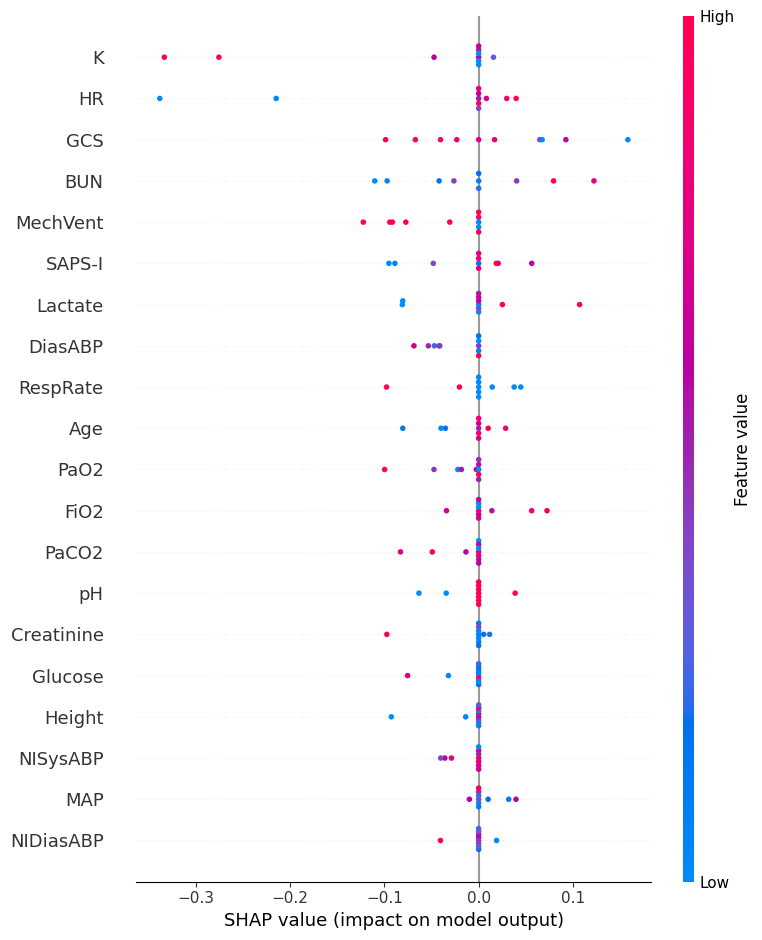

<Figure size 640x480 with 0 Axes>

In [49]:
if 'shap_values' in locals() and 'sample_concat' in locals():
    print("Generating SHAP summary plot...")

    # Handle 3D SHAP values if necessary
    if len(np.shape(shap_values)) == 3:
        if np.shape(shap_values)[2] > 1:
            shap_values_2d = shap_values[:, :, 1]  # Positive class
            print(f"Using SHAP values for positive class. Shape: {np.shape(shap_values_2d)}")
        else:
            shap_values_2d = shap_values[:, :, 0]  # Single output
            print(f"Using SHAP values for single output. Shape: {np.shape(shap_values_2d)}")
    else:
        shap_values_2d = shap_values
        print(f"Using 2D SHAP values. Shape: {np.shape(shap_values_2d)}")

    # Ensure feature names are available
    if 'feature_names' not in locals():
        print("Warning: Using generic feature names.")
        feature_names = [f'feature_{i}' for i in range(sample_concat.shape[1])]

    # Validate dimensions
    print(f"Feature names: {len(feature_names)}, SHAP features: {np.shape(shap_values_2d)[1]}")

    # Generate summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_2d, sample_concat, feature_names=feature_names)
    plt.tight_layout()
    plt.show()

else:
    print("Error: SHAP values not found. Run SHAP calculation cell first.")

## Final Conclusion

Based on the evaluation of the CNN-LSTM model for 36-hour temporal ICU mortality prediction:

**Results Summary:**

*   **Overall Performance:** The model demonstrates moderate discriminatory ability with an AUROC of 0.77. The AUPRC of 0.36 suggests limitations in achieving high precision and recall simultaneously, particularly in correctly identifying positive cases without a high number of false positives.
*   **Confusion Matrix:** The confusion matrix highlights that while the model correctly identifies a large number of survivors (True Negatives = 390), it also has a significant number of false positives (299), meaning it predicts death for many patients who survive. The number of false negatives (19) is relatively low, indicating the model is less likely to miss a patient who dies.
*   **Feature Importance (SHAP):** The SHAP analysis reveals that **Potassium (K)** and **Heart Rate (HR)** are the most influential features in the model's predictions. High Potassium and high Heart Rate values are associated with an increased risk of mortality. Other important features include **GCS**, **BUN**, **Mechanical Ventilation**, and **SAPS-I**, with lower GCS scores contributing to higher risk.
*   **Early Prediction Capability:** The current model demonstrates the ability to achieve good accuracy and recall using only the first 36 hours of ICU data. This early prediction capability is crucial for enabling faster clinical interventions and potentially improving patient outcomes by allowing healthcare providers to identify high-risk patients sooner.

**Key Points:**

*   **Resource Allocation:** The model could help identify patients at high risk of mortality, allowing hospitals to prioritize resources, such as staffing, equipment, and interventions, to improve patient outcomes and potentially reduce costs associated with prolonged ICU stays.
*   **Early Intervention:** By predicting mortality risk early (within 36 hours), the model could alert clinicians to patients who may benefit from more aggressive or timely interventions, potentially preventing deterioration and improving survival rates.
*   **Clinical Decision Support:** The model's predictions and feature importance insights could serve as a valuable tool for clinicians, providing data-driven support for complex decisions related to patient care, prognostication, and family discussions.
*   **Quality Improvement:** Analyzing model performance and common false positives/negatives could help identify areas for improvement in clinical protocols, data collection, and patient management within the ICU.
*   **Benchmarking and Performance Monitoring:** The model could be used to benchmark the performance of different ICUs or track changes in mortality rates over time, providing insights for quality improvement initiatives.